# Sensitivity analysis


## t-closeness

This analysis uses methodology from Google's paper 
"Measuring Sensitivity of Cohorts Generated by the FLoC API" 
<<a href="https://docs.google.com/a/chromium.org/viewer?a=v&pid=sites&srcid=Y2hyb21pdW0ub3JnfGRldnxneDo1Mzg4MjYzOWI2MzU2NDgw">link</a>>

See section "Utility vs privacy"

![title](../docs/google_t_closeness_analysis.png)



We set up a dummy panel representing the U.S. population w.r.t. size and distribution of race.

We randomly assign cohort IDs s.t. each cohort has at least k=2000 members.

In [1]:
from datetime import datetime
import random
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from census import Census
import us


# YEAR = 2017 
YEAR = 2019 # <-- most recent year of data available
c = Census("14a343e581b5dd1df551f4cd87f31aede50ec908", year=YEAR)

## Retrieving census data

I went [here](https://api.census.gov/data/2017/acs/acs5/profile/variables.html) and looked up relevant variables and just hand-coded them below.

In [2]:
total_population_estimate = c.acs5dp.us(['DP05_0070E'])[0]['DP05_0070E']
print('%s total population estmate: %s' % (YEAR, total_population_estimate))

2019 total population estmate: 324697795.0


In [3]:
census_df = pd.DataFrame([
    ['DP05_0077E', 'white', 'non-hispanic white'], 
    ['DP05_0078E', 'black', 'non-hispanic black'],
    ['DP05_0080E', 'asian', 'non-hispanic asian'],
    # other  -- there are other categories in census. sum them into other
], columns=['census_code', 'name', 'description'])

# API call to get the values
census_df['value'] = census_df.census_code.map(
    c.acs5dp.us(list(census_df.census_code.values))[0]
)
# add in 'other'
census_df = census_df.append({
    'census_code': np.nan,
    'name': 'other',
    'description': 'total population less non-hispanic white, black, asian',
    'value': total_population_estimate - census_df.value.sum(),
}, ignore_index=True)

census_df

,census_code,name,description,value
0,DP05_0077E,white,non-hispanic white,197100373.0
1,DP05_0078E,black,non-hispanic black,39977554.0
2,DP05_0080E,asian,non-hispanic asian,17708954.0
3,NaN,other,"total population less non-hispanic white, blac...",69910914.0


## Panel formation

Make a dummy panel representing the U.S. race distribution.

```
mid, race, cohort
```

where
- mid is a fake machine_id

We scale the size of the panel to the size of the Google Chrome OT trial.

[According to the Chrome team](https://sites.google.com/a/chromium.org/dev/Home/chromium-privacy/privacy-sandbox/floc), for the OT trial:
- k=2000
- Number of cohorts, before any filtering: 33,872

We might assume that the average cohort size was then 3,000 based on the below analysis

And that there were then ~ 3000 x 33,872 total devices in the trial


#### Estimating origin trial size.

[According to the Chrome team](https://sites.google.com/a/chromium.org/dev/Home/chromium-privacy/privacy-sandbox/floc), for the OT trial:
- k=2000
- Number of cohorts, before any filtering: 33,872


The question is then what the cohorts sizes were, or how many total devices were included in the trial.

To estimate this:

We can use our real browsing data, which is a much smaller sample than Google's sample for the OT.

We use our preprocessed browsing history and FLoC PrefixLSH implementation to determine whether there are consistent patterns / relationships between k and the average number and distribution of cohort sizes.

In [4]:
# read in preprocessed browsing data
# weeks,machine,domains,simhash (weeks_machines_domains)

wmd_simhash_fpath = '../output/wmd_simhash.csv'

wmd_df = pd.read_csv(wmd_simhash_fpath)
print('read in %s total rows' % len(wmd_df))
wmd_df.drop('domains', axis=1).head()

read in 4877236 total rows


,machine_id,week,n_domains,simhash
0,169007206,1,104,1.585204e+14
1,170331223,1,0,NaN
2,170422065,1,20,5.322881e+14
3,170911221,1,49,7.213568e+14
4,171771316,1,64,6.710488e+14


Limit data to machine, weeks with sufficient data for cohort generation: >= 7 domains

In [5]:
n_domains_threshold = 7
print('dropping machine weeks with < %s domains' % n_domains_threshold)
wmd_df = wmd_df[wmd_df.n_domains >= n_domains_threshold]
print('%s data rows' % len(wmd_df))

dropping machine weeks with < 7 domains
2073405 data rows


In [6]:
import prefixLSH

cohort_ks = [2000,1000,500,250,125]

for k in cohort_ks:
    print('computing cohorts for k=%s' % k)
    t_start = datetime.now()
    cohorts_dict = prefixLSH.get_cohorts_dict(wmd_df.simhash.astype(int), min_k=k)
    wmd_df['cohort_%s'%k] = wmd_df.simhash.map(cohorts_dict)
    print('took %s' % (datetime.now() - t_start))

computing cohorts for k=2000
took 0:00:30.137885
computing cohorts for k=1000
took 0:00:42.068308
computing cohorts for k=500
took 0:01:03.069186
computing cohorts for k=250
took 0:01:50.849429
computing cohorts for k=125
took 0:03:26.141822


In [7]:
wmd_df.head(3)

,machine_id,week,n_domains,domains,simhash,cohort_2000,cohort_1000,cohort_500,cohort_250,cohort_125
0,169007206,1,104,"{'2dopeboyz.com', 'offers.com', 'wordpress.com...",1.585204e+14,83,165,316,667,1337
2,170422065,1,20,"{'shein.com', 'refinery29.com', 'messenger.com...",5.322881e+14,263,533,1012,2141,4306
3,170911221,1,49,"{'8haodangpu.cc', 'vjav.com', '51luoben.com', ...",7.213568e+14,381,754,1468,3088,6242



k=2000: 664.0 total cohorts; mean cohort size = 3122.60
mean cohort size / k = 1.56

k=1000: 1279.0 total cohorts; mean cohort size = 1621.11
mean cohort size / k = 1.62

k=500: 2562.0 total cohorts; mean cohort size = 809.29
mean cohort size / k = 1.62

k=250: 5403.0 total cohorts; mean cohort size = 383.75
mean cohort size / k = 1.54

k=125: 10800.0 total cohorts; mean cohort size = 191.98
mean cohort size / k = 1.54


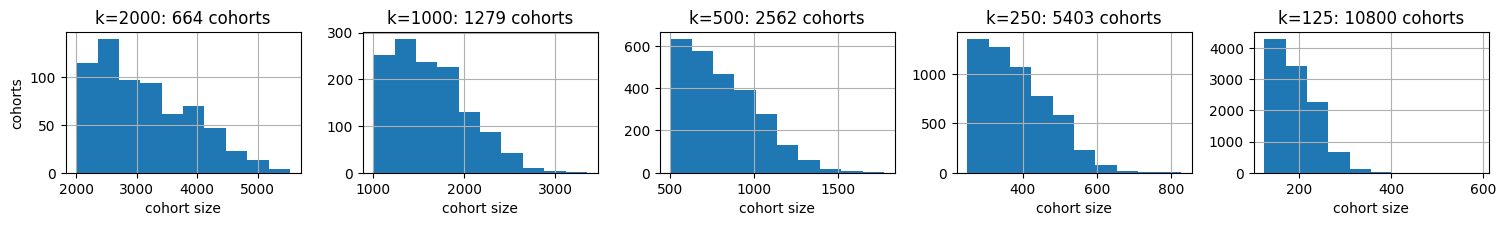

In [8]:
ks = len(cohort_ks)
fig, axes = plt.subplots(1, ks, figsize=(ks*3, 2), dpi=100)
plt.tight_layout()

for i, k in enumerate(cohort_ks):
    ax = axes[i]
    value_counts = wmd_df['cohort_%s'%k].value_counts()
    value_counts_d = value_counts.describe()
    print('\nk=%s: %s total cohorts; mean cohort size = %0.2f' % (
        k, value_counts_d['count'], value_counts_d['mean']
    ))
    # print(value_counts_d)
    value_counts.hist(ax=ax)
    ax.set_title('k=%s: %s cohorts' % (
        k, int(value_counts_d['count'])))
    ax.set_xlabel("cohort size")
    print('mean cohort size / k = %0.2f' %(value_counts_d['mean']/k))
_ = axes[0].set_ylabel("cohorts")
plt.show()


We might assume that the average cohort size was 3,000 (k=2000 x 1.5) based on the above analysis

And that there were then ~ 3000 x 33,872 total devices in the trial

In [9]:
OT_cohort_N = 33872
OT_mid_N = OT_cohort_N*3000
print('OT_mid_N:', OT_mid_N)
print('OT_mid_N / total population = %s / %s = %0.3f' % (
    OT_mid_N, total_population_estimate, OT_mid_N/total_population_estimate
))

OT_mid_N: 101616000
OT_mid_N / total population = 101616000 / 324697795.0 = 0.313


### Random OT panel creation

In [10]:
census_df['OT_scaled_value'] = (census_df.value * (OT_mid_N/total_population_estimate)).apply(round)
print('OT total population = %s' % census_df['OT_scaled_value'].sum())
census_df

OT total population = 101616000


,census_code,name,description,value,OT_scaled_value
0,DP05_0077E,white,non-hispanic white,197100373.0,61683670
1,DP05_0078E,black,non-hispanic black,39977554.0,12511200
2,DP05_0080E,asian,non-hispanic asian,17708954.0,5542117
3,NaN,other,"total population less non-hispanic white, blac...",69910914.0,21879013


In [11]:
# create list of race values representing panel

census_race_count_dict = census_df.set_index('name')['OT_scaled_value'].to_dict()
race_counts = [[r]*c for (r, c) in census_race_count_dict.items()]
races = [r for r_c in race_counts for r in r_c]

In [12]:
random.seed(0)

In [13]:
# create list of cohort IDs
# representing the 33,872 cohorts from the origin trial
# where each cohort has minimum k=2000

k=2000

def get_cohorts_random_uniform(N, k=k, cohorts=OT_cohort_N):
    """
    Returns series of cohort IDs uniformly randomly assigned.
    Each cohort has size >= k
    """
    if N < (k*cohorts):
        raise Exception('N must be larger than k x number of cohorts')
    cohort_ids = list(range(cohorts))*k
    cohort_ids += list(np.random.randint(cohorts, size=(OT_mid_N - len(cohort_ids))))
    return pd.Series(cohort_ids) + 1

In [14]:
def get_OT_random_panel_cohorts_df(races=races, N=OT_mid_N):
    """
    Returns panel mapping (fake) machine ids (mid) to cohort and race.
    Distribution of race values matches true population.
    Size and number of cohorts in the panel matches the Google Chrome 
    origin trial (OT). 
    Yet cohorts are randomly distributed and matched to mids and races.
    """
    if len(races) != N:
        raise Exeception('number of values for races must match N')
    cohort_ids = get_cohorts_random_uniform(N)
    mid = list(range(OT_mid_N))
    random.shuffle(mid)
    panel_df = pd.DataFrame({
        'mid': mid,
        'cohort': cohort_ids,
    }).sort_values('mid')
    panel_df['race'] = races
    return panel_df

In [15]:
panel_df = get_OT_random_panel_cohorts_df()

In [16]:
len(panel_df)

101616000

In [17]:
panel_df.head()

,mid,cohort,race
85373251,0,29422,white
44490303,1,16368,white
3979202,2,16179,white
63861290,3,12571,white
40707293,4,27022,white


In [18]:
panel_df.cohort.value_counts().describe()

count    33872.000000
mean      3000.000000
std         31.550751
min       2867.000000
25%       2979.000000
50%       3000.000000
75%       3021.000000
max       3127.000000
Name: cohort, dtype: float64

## Panel analysis

In [19]:
cohort_race_counts_df = panel_df.groupby(
    ['cohort','race']
).count()['mid'].rename('count').to_frame().reset_index('race')
cohort_race_counts_df.head()

,race,count
cohort,,
1,asian,181
1,black,349
1,other,643
1,white,1866
2,asian,170


In [20]:
cohort_race_counts_df['total'] = panel_df.groupby('cohort').count().mid
cohort_race_counts_df['portion'] = cohort_race_counts_df['count']/cohort_race_counts_df['total']
cohort_race_counts_df.head(10)

,race,count,total,portion
cohort,,,,
1,asian,181,3039,0.059559
1,black,349,3039,0.114840
1,other,643,3039,0.211583
1,white,1866,3039,0.614018
2,asian,170,2999,0.056686
2,black,355,2999,0.118373
2,other,643,2999,0.214405
2,white,1831,2999,0.610537
3,asian,161,3009,0.053506



race: asian
panel fraction: 0.05
count    33872.000000
mean         0.054540
std          0.004101
min          0.037074
25%          0.051718
50%          0.054498
75%          0.057321
max          0.071810
Name: portion, dtype: float64

race: black
panel fraction: 0.12
count    33872.000000
mean         0.123123
std          0.005982
min          0.099262
25%          0.119072
50%          0.123095
75%          0.127128
max          0.150336
Name: portion, dtype: float64

race: other
panel fraction: 0.22
count    33872.000000
mean         0.215310
std          0.007488
min          0.183612
25%          0.210197
50%          0.215266
75%          0.220396
max          0.248753
Name: portion, dtype: float64

race: white
panel fraction: 0.61
count    33872.000000
mean         0.607027
std          0.008901
min          0.563447
25%          0.601050
50%          0.607036
75%          0.613032
max          0.641547
Name: portion, dtype: float64


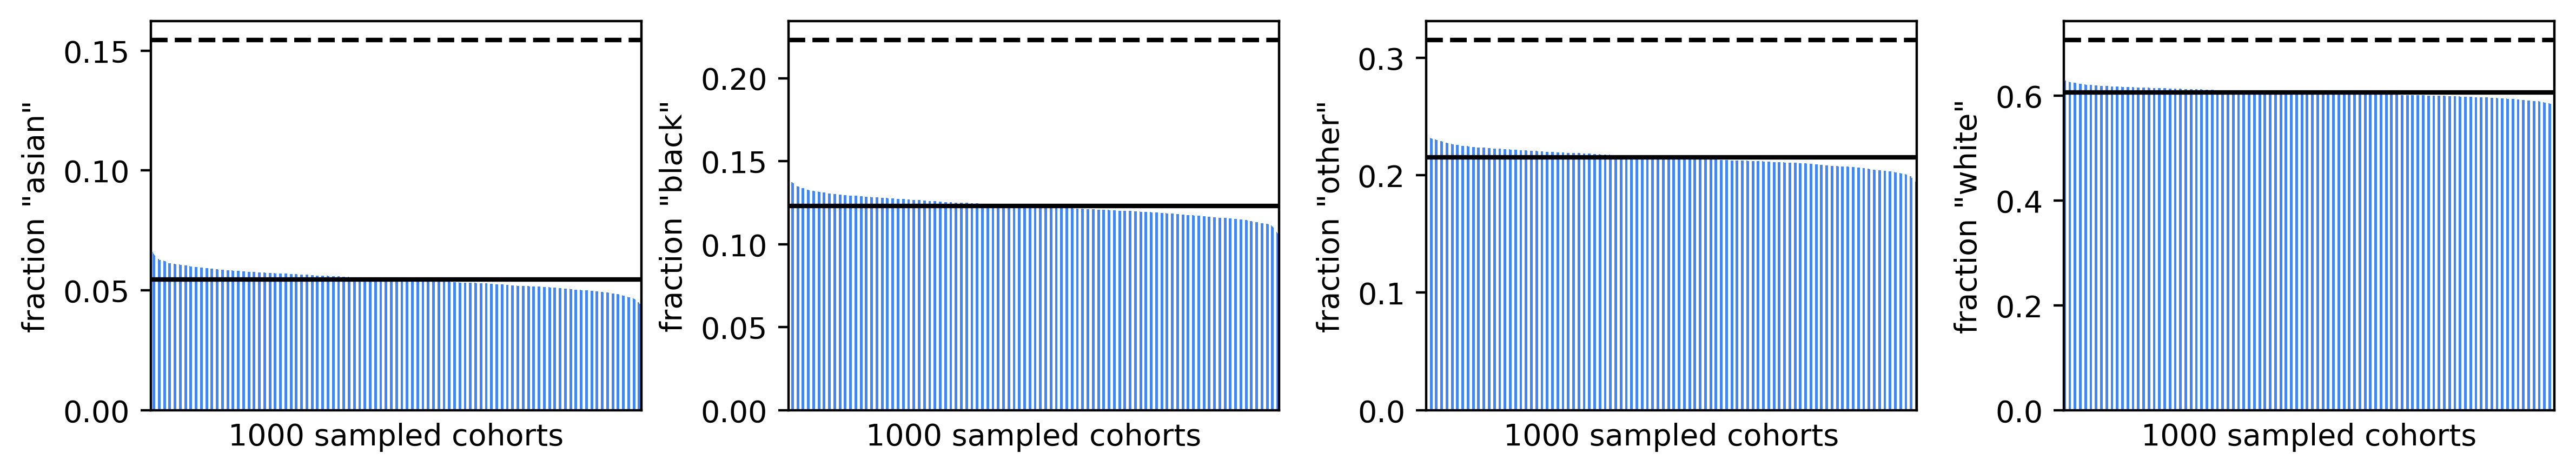

In [26]:
random_cohort_sample_N = 1000 # plot random sample

from style_config import BLUE

t = 0.1
dpi=400

races = cohort_race_counts_df.race.unique()

fig, axes = plt.subplots(1,len(races),figsize=(3*len(races),2.5), dpi=dpi)
plt.tight_layout(pad=1.5)

for i, race in enumerate(races):
    print('\nrace:', race)
    panel_fraction = len(panel_df[panel_df.race==race])/len(panel_df)
    print('panel fraction: %0.2f' % panel_fraction)
    # fig, ax = plt.subplots(1,1,figsize=(6,3), dpi=dpi)
    ax = axes[i]
    portions = cohort_race_counts_df[(cohort_race_counts_df.race==race)].portion
    print(portions.describe())
    portions_sample = pd.Series(np.random.choice(portions, size=random_cohort_sample_N))
    portions_sample.sort_values(ascending=False).plot.bar(ax=ax, label="", color=BLUE)
    ax.hlines(y=panel_fraction, xmin=0, xmax=len(ax.get_xticks()), 
              linestyles='-', color='black', label='mean')
    ax.hlines(y=panel_fraction+t, xmin=0, xmax=len(ax.get_xticks()), 
              linestyles='--', color='black', label='mean + t=0.1')
    ax.set_xticks([])
    ax.set_xlabel('%s sampled cohorts' % random_cohort_sample_N)
    ax.set_ylabel('fraction "%s"' % race)